In [1]:
import os

os.environ['TF_METAL_AMP_ENABLED'] = 'false'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
import time

In [3]:
zip_file_path = './task2.zip'
extraction_directory = 'extracted_images/'

In [4]:
y_train = pd.read_csv(extraction_directory + 'y_train.csv', index_col='id')
y_train_np = y_train['y'].to_numpy()

In [5]:
X_train = pd.read_csv(extraction_directory + 'X_train.csv', index_col='id')
X_train_np = X_train.to_numpy()

In [6]:
def replicate_row(row):
    # Find the length of the non-NaN part
    valid_length = np.argmax(row.isna())
    valid_length = valid_length if valid_length > 0 else len(row)

    # Repeat the non-NaN part and truncate to match the original length
    repeated = np.tile(row[:valid_length], len(row) // valid_length + 1)[:len(row)]
    return pd.Series(repeated)

start = time.time()

X_train_periodic = X_train.apply(replicate_row, axis=1)

end = time.time()
print(f"Time taken: {end - start} seconds")

Time taken: 0.9607119560241699 seconds


In [7]:
X_train_periodic_np = X_train_periodic.to_numpy()

In [18]:
S_dict = {}

for ind in range(X_train_periodic_np.shape[0]):

    if ind == 1870:
        S_dict[ind] = (0,)*7
        continue
    
    measurements = X_train_filtered.iloc[ind].dropna().to_numpy(dtype='float32')
    rpeaks = np.array(correct_rpeaks(measurements, nk.ecg_peaks(measurements, sampling_rate=300)[1]['ECG_R_Peaks'], 300, .15)[0])
    rpeaks_ = np.array(correct_rpeaks(-measurements, rpeaks, 300, .1)[0])
    if not len(rpeaks)==len(rpeaks_):
        rpeaks = rpeaks[:len(rpeaks_)]
    
    _, waves_peak = nk.ecg_delineate(measurements, 
                                    rpeaks, 
                                    sampling_rate=300, 
                                    method="peak", 
                                    show=False, 
                                    show_type='peaks')
    _, waves_peak_ = nk.ecg_delineate(-measurements, 
                                    rpeaks_, 
                                    sampling_rate=300, 
                                    method="peak", 
                                    show=False, 
                                    show_type='peaks')
    
    tpeaks = pd.Series(waves_peak['ECG_T_Peaks']).ffill().to_numpy().astype(int);
    # speaks = pd.Series(waves_peak['ECG_S_Peaks']).ffill().to_numpy().astype(int);
    tpeaks_ = pd.Series(waves_peak_['ECG_T_Peaks']).ffill().to_numpy().astype(int);
    # seaks_ = pd.Series(waves_peak_['ECG_S_Peaks']).ffill().to_numpy().astype(int);
    rpeaks_med = np.median(measurements[rpeaks])
    rpeaks_med_ = np.median(measurements[rpeaks_])

    if len(rpeaks) > 0 and len(rpeaks_) > 0 and rpeaks_med>0:
        S_dict[ind] = ( np.mean(rpeaks - rpeaks_),
                        np.median(rpeaks - rpeaks_),
                        -(rpeaks_med+np.median(measurements[tpeaks])) / (rpeaks_med_+np.median(measurements[tpeaks_])),
                        rpeaks_med,
                        np.median(measurements[tpeaks]),
                        rpeaks_med_,
                        np.median(measurements[tpeaks_]),
                        )
    else:
        S_dict[ind] = (0,)*7

/var/folders/n2/rfc_8wbn4n5bqd9_rm70nslh0000gn/T/ipykernel_75098/3669277101.py:30: RuntimeWarning: invalid value encountered in cast
  tpeaks_ = pd.Series(waves_peak_['ECG_T_Peaks']).ffill().to_numpy().astype(int);
/var/folders/n2/rfc_8wbn4n5bqd9_rm70nslh0000gn/T/ipykernel_75098/3669277101.py:28: RuntimeWarning: invalid value encountered in cast
  tpeaks = pd.Series(waves_peak['ECG_T_Peaks']).ffill().to_numpy().astype(int);
/var/folders/n2/rfc_8wbn4n5bqd9_rm70nslh0000gn/T/ipykernel_75098/3669277101.py:30: RuntimeWarning: invalid value encountered in cast
  tpeaks_ = pd.Series(waves_peak_['ECG_T_Peaks']).ffill().to_numpy().astype(int);
/var/folders/n2/rfc_8wbn4n5bqd9_rm70nslh0000gn/T/ipykernel_75098/3669277101.py:30: RuntimeWarning: invalid value encountered in cast
  tpeaks_ = pd.Series(waves_peak_['ECG_T_Peaks']).ffill().to_numpy().astype(int);
/var/folders/n2/rfc_8wbn4n5bqd9_rm70nslh0000gn/T/ipykernel_75098/3669277101.py:28: RuntimeWarning: invalid value encountered in cast
  tpeaks 

In [19]:
S_ser = pd.DataFrame(S_dict).T
S_ser[7] = S_ser[3] / S_ser[4]
S_ser[8] = S_ser[5] / S_ser[6]
indexes_to_invert = S_ser[(
                            ((S_ser[3] >  1.5 ) & (S_ser[8] < 3   ) & (S_ser[2] < 5 )) |
                            ((S_ser[3] >  -.5 ) & (S_ser[8] < 2   ) & (S_ser[2] < 5 )) |
                            ((S_ser[3] >  0.5 ) & (S_ser[2] < 2   )) |
                            ((S_ser[3] > -0.65) & (S_ser[2] < 0.6 )) |
                            ((S_ser[3] > -1.4 ) & (S_ser[2] < 0.1 ))
                            )].index.to_list()

for ind in indexes_to_invert:
    X_train_periodic_np[ind] = -X_train_periodic_np[ind]

In [20]:
from numpy.random import RandomState

prng = RandomState(1)

def augment_signal(signal, max_shift, scaling_factor_range, noise_level, max_freq_change):
    signal = signal.copy()
    # Time Shifting
    if max_shift > 0:
        shift = prng.randint(-max_shift, max_shift)
        signal = np.roll(signal, shift)

    # Scaling
    if scaling_factor_range > 0:
        signal *= prng.uniform(1 - scaling_factor_range, 1 + scaling_factor_range)

    # Adding Noise
    if noise_level > 0:
        signal += pd.DataFrame(prng.normal(0, noise_level, size=signal.size + 500)).rolling(window=500).median().to_numpy().squeeze()[500:]

    # Frequency Change (Resampling)
    if max_freq_change > 0:
        freq_change = prng.uniform(1 - max_freq_change, 1 + max_freq_change)
        resample_size = int(len(signal) * freq_change)
        if freq_change > 1:
            signal = np.interp(np.linspace(0, 1, resample_size), np.linspace(0, 1, len(signal)), signal)[:signal.size]
        elif freq_change < 1:
            signal = np.tile(np.interp(np.linspace(0, 1, resample_size), np.linspace(0, 1, len(signal)), signal), 2)[:signal.size]
    return signal


In [21]:
signal_ids = dict()
for class_label in range(4):
    signal_ids[class_label] = []
for class_label in range(4):
    for i in range(X_train.shape[0]):
        if y_train_np[i] == class_label:
            signal_ids[class_label].append(i)

In [22]:
multiplier = 2

class_distribution = y_train.apply(lambda x: {i: x[x == i].count() for i in range(4)})['y']
print('Original:')
for name in class_distribution:
    print(str(name) + ': {:} = {:.2%}'.format(class_distribution[name] , class_distribution[name] / y_train_np.size))
print('')

y_train_np = y_train.to_numpy().squeeze()

# Parameters for augmentation
max_shift = 1200  # Maximum shift for time shifting
scaling_factor_range = 0.05  # Scaling factor range for scaling
noise_level = 1000  # Noise level for adding noise
max_freq_change = 0.03  # Maximum frequency change for resampling

# Augmenting the dataset
X_augmented = []
y_augmented = []

for class_label, repetitions in enumerate([((X_train.shape[0] * multiplier) // v) for v in class_distribution.values()]):
    for _ in range(repetitions):
        for index in signal_ids[class_label]:
            augmented_signal = augment_signal(X_train_periodic_np[i], max_shift, scaling_factor_range, noise_level, max_freq_change)
            X_augmented.append(augmented_signal)
            y_augmented.append(class_label)

# X_train_extended_np = np.array(X_augmented)
# y_train_extended_np = np.array(y_augmented)

X_train_extended_np = np.concatenate((X_train_periodic_np, X_augmented))
y_train_extended_np = np.concatenate((y_train_np, y_augmented))

X_train_extended = pd.DataFrame(X_train_extended_np, columns=X_train.columns)
y_train_extended = pd.DataFrame(y_train_extended_np, columns=y_train.columns)

class_distribution_extended = y_train_extended.apply(lambda x: {i: x[x == i].count() for i in range(4)})['y']
print('Extended:')
for name in class_distribution_extended:
    print(str(name) + ': {:} = {:.2%}'.format(class_distribution_extended[name], class_distribution_extended[name] / y_train_extended_np.size))

Original:
0: 3030 = 59.21%
1: 443 = 8.66%
2: 1474 = 28.81%
3: 170 = 3.32%

Extended:
0: 12120 = 27.90%
1: 10632 = 24.48%
2: 10318 = 23.75%
3: 10370 = 23.87%


In [23]:
def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    res += ((res%2) - 1) # needs to be an odd number
    return res

# ms_flt_array = [0.2,0.6]
ms_flt_array = [0.4,0.8]

def filter_line(data, ms_flt_array):
    data = data.copy()

    for i in range(0, len(ms_flt_array)):
        window_size = get_median_filter_width(300, ms_flt_array[i])

        data -= data.apply(lambda x: x.rolling(window=window_size, center=True, min_periods=1).median(), axis=1)

    return data

X_train_filtered = filter_line(X_train_extended, ms_flt_array)
X_train_filtered_np = X_train_filtered.to_numpy()

In [24]:
total_length = X_train.shape[1]

def denoise_signal_with_selective_thresholding(signal, wavelet, level, qrs_band=(5, 15), sampling_rate=300, dampening=2):
    # Decompose to get the wavelet coefficients
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Calculate the frequency bands for each level of decomposition
    freqs = pywt.scale2frequency(wavelet, [1, 2, 4, 8, 16, 32, 64]) * sampling_rate

    # Calculate a universal threshold
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))

    # Apply selective thresholding
    new_coeffs = []
    for i, coeff in enumerate(coeffs[1:], start=1):  # Skip the approximation coefficients
        if freqs[i-1] >= qrs_band[0] and freqs[i-1] <= qrs_band[1]:
            # If within QRS band, apply a softer threshold or skip thresholding
            new_coeffs.append(pywt.threshold(coeff, value=threshold/dampening, mode='soft'))
        else:
            # Else, apply the regular threshold
            new_coeffs.append(pywt.threshold(coeff, value=threshold, mode='soft'))
    
    # Reconstruct the signal using modified coefficients
    coeffs[1:] = new_coeffs
    return pywt.waverec(coeffs, wavelet)

def process_signal(signal, wavelet, level, qrs_band=(5, 15), sampling_rate=300, dampening=2):
    global total_length
    # Find the index of the first NaN value
    nan_index = np.argmax(np.isnan(signal))
    if nan_index == 0:  # No NaNs found
        return denoise_signal_with_selective_thresholding(signal, wavelet, level, qrs_band=qrs_band, sampling_rate=sampling_rate, dampening=dampening)
    
    a = np.empty((total_length-nan_index,))
    a[:] = np.nan

    return np.concatenate([denoise_signal_with_selective_thresholding(signal[:nan_index], wavelet, level, qrs_band=qrs_band, sampling_rate=sampling_rate, dampening=dampening), a])[0:total_length]

In [25]:
wavelet = 'db4'  # Example wavelet, choose as per your requirement
level = 3 # Decomposition level
qrs_band = (50, 150)  # Frequency band of QRS complex in Hz
sampling_rate = 300  # Sampling rate of ECG signal in Hz
dampening = 1

X_train_denoised_np = np.array([process_signal(row, wavelet, level, qrs_band, sampling_rate, dampening)[0:total_length] for row in X_train_filtered_np])
X_train_denoised = pd.DataFrame(data=X_train_denoised_np, columns=X_train_extended.columns, index=X_train_extended.index)

In [26]:
from biosppy.signals.ecg import correct_rpeaks
from ecgdetectors import Detectors
import biosppy.signals.ecg as ecg
import neurokit2 as nk
from sklearn.preprocessing import RobustScaler, StandardScaler

X_train_transformed = StandardScaler().fit_transform(X_train_denoised_np)
X_train_transformed_np = np.array(X_train_transformed)

In [27]:
def normalize_signal(signal):

    detectors = Detectors(300)

    r_peaks = correct_rpeaks(signal, np.asarray(detectors.pan_tompkins_detector(signal)), 300, 0.2)['rpeaks']
    vals_peaks = signal[r_peaks]
    median_peak_val = np.median(vals_peaks[~np.isnan(vals_peaks)])
    
    if median_peak_val != 0:
        if np.isnan(median_peak_val).any():
            print(median_peak_val)
        return signal / median_peak_val
    # else:
    #     print(median_peak_val)
    #     return RobustScaler(quantile_range=(.2,.8)).fit_transform(signal.T).T/5

X_train_transformed_np = np.apply_along_axis(normalize_signal, 1, X_train_denoised_np)[:,::2]
# X_train_transformed = pd.DataFrame(data=X_train_transformed_np, columns=X_train_denoised.columns, index=X_train_denoised.index)

def extract_features(signal):
    
    r_peaks = correct_rpeaks(signal, np.asarray(Detectors(300).pan_tompkins_detector(signal)), 300, 0.2)['rpeaks']
    
    beats = ecg.extract_heartbeats(signal, r_peaks, 300, before=.5, after=.5)['templates']

    if len(beats) == 0:
        raise Exception()

    a = np.zeros_like(signal)    
    a[r_peaks] = 1

    # continuous features
    
    mu = np.mean(beats, axis=0) 
    var = np.std(beats, axis=0)
    quant_001 = np.quantile(beats, q=.001, axis=0)
    quant_05 = np.quantile(beats, q=.05, axis=0)
    quant_1 = np.quantile(beats, q=.1, axis=0)
    quant_2 = np.quantile(beats, q=.2, axis=0)
    quant_3 = np.quantile(beats, q=.3, axis=0)
    quant_4 = np.quantile(beats, q=.4, axis=0)
    md = np.median(beats, axis=0)
    quant_6 = np.quantile(beats, q=.6, axis=0)
    quant_7 = np.quantile(beats, q=.7, axis=0)
    quant_8 = np.quantile(beats, q=.8, axis=0)
    quant_9 = np.quantile(beats, q=.9, axis=0)
    quant_95 = np.quantile(beats, q=.95, axis=0)
    quant_999 = np.quantile(beats, q=.999, axis=0)

    return np.array([mu, var, quant_001, quant_05, quant_1, quant_2, quant_3, quant_4, md, quant_6, quant_7, quant_8, quant_9, quant_95, quant_999]).T

X_train_ready_np = np.array([extract_features(row) for row in X_train_transformed_np])

# OBTAIN TEST DATA

In [28]:
X_test  = pd.read_csv(extraction_directory + 'X_test.csv', index_col='id')
X_test_np = X_test.to_numpy()

X_test_periodic = X_test.apply(replicate_row, axis=1)
X_test_periodic_np = X_test_periodic.to_numpy()

X_test_filtered = filter_line(X_test_periodic, ms_flt_array)
X_test_filtered_np = X_test_filtered.to_numpy()

X_test_denoised_np = np.array([process_signal(row, wavelet, level, qrs_band, sampling_rate, dampening)[0:total_length] for row in X_test_filtered_np])
X_test_denoised = pd.DataFrame(data=X_test_denoised_np, columns=X_test.columns, index=X_test.index)

# X_test_transformed = StandardScaler().fit_transform(X_test_denoised_np)
# X_test_transformed_np = np.array(X_test_transformed)
X_test_transformed_np = np.apply_along_axis(normalize_signal, 1, X_test_denoised_np)[:,::2]

# X_test_ready_np = np.array([extract_features(row) for row in X_test_transformed_np])

# MODEL TRAINING

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.models import Sequential, Model
from tensorflow.keras.layers import ELU, LSTM, Dense, Input, concatenate, MaxPool2D, BatchNormalization, Dropout, Conv1D, Flatten, MaxPooling1D, Conv2D, Input, Concatenate, GlobalAveragePooling1D, Activation
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import tensorflow as tf

In [30]:
# Convert labels to categorical
y_train_cat_np = to_categorical(y_train_extended.to_numpy())

# Split data
X_train_partial, X_val, y_train_partial, y_val = train_test_split(X_train_transformed_np, y_train_cat_np, test_size=0.2, random_state=23)

In [63]:
x

<KerasTensor: shape=(None, 8904, 1) dtype=float32 (created by layer 'input_22')>

In [73]:
keras.backend.repeat_elements(x, rep=3, axis=2)

<KerasTensor: shape=(None, 8904, 3) dtype=float32 (created by layer 'tf.concat_3')>

In [85]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Conv1D, MaxPooling1D, Add, GlobalAveragePooling1D
import keras

input_shape = (X_train_partial.shape[1], 1)
num_classes = 4
CNN_dropout_rate = 0.4
dropout_rate = 0.3
learning_rate = .05
clipnorm = 1.0
filter_size_list = [8,5,3]
channels_list = [512, 512, 512]
fc_neurons = [512, 256]

# CNN_double_layers = 7

inputs = Input(shape=input_shape)
x = inputs

for i, channels in enumerate(channels_list):
    y = x
    for filter_size in filter_size_list:
        y = Conv1D(channels, filter_size, padding='same', activation='linear')(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
    # y = Dropout(CNN_dropout_rate)(y)
    x = Add()([keras.backend.repeat_elements(x, rep=y.shape[2] // x.shape[2], axis=2), y])
    if not i==(len(channels_list)-1):
        x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Dropout(CNN_dropout_rate)(x)

x = GlobalAveragePooling1D()(x)
# x = BatchNormalization()(x)
# x = Dropout(dropout_rate)(x)

for neurons in fc_neurons:
    x = Dense(neurons, activation='linear')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

x = Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=x)

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))#, clipnorm=clipnorm))
print(model.summary())

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, 8904, 1)]            0         []                            
                                                                                                  
 conv1d_236 (Conv1D)         (None, 8904, 512)            4608      ['input_29[0][0]']            
                                                                                                  
 batch_normalization_269 (B  (None, 8904, 512)            2048      ['conv1d_236[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_254 (Activation  (None, 8904, 512)            0         ['batch_normalization_2

In [86]:
# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=2,
                             verbose=0,
                             factor=0.1,
                             min_lr=1e-9)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0, 
                           patience=500,
                           verbose=1,
                           mode='max',
                           baseline=0.75,
                           start_from_epoch=1,
                           restore_best_weights=True)

checkpoint_filepath = '/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/AML/task2/model_CNN_ggg.h5'
model_checkpoint_callback = ModelCheckpoint(
                            filepath=checkpoint_filepath,
                            monitor='val_accuracy',
                            mode='max',
                            initial_value_threshold=0.5,
                            save_best_only=True)

In [89]:
start = time.time()
History = model.fit(X_train_partial[:1000],
                    y_train_partial[:1000],
                    epochs=500,
                    batch_size=500,
                    validation_split=0.0,
                    validation_data=(X_val[:500], y_val[:500]),
                    shuffle=True,
                    callbacks=[lr_decay],
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

Epoch 1/500


In [ ]:
start = time.time()
History = model.fit(X_train_partial[:5000],
                    y_train_partial[:5000],
                    epochs=5000,
                    batch_size=100,
                    validation_split=0.0,
                    validation_data=(X_val[:1000], y_val[:1000]),
                    shuffle=True,
                    callbacks=[lr_decay, early_stop, model_checkpoint_callback],
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

Epoch 1/5000
50/50 [==============================] - 13s 192ms/step - loss: 1.6292 - accuracy: 0.2772 - val_loss: 1.7906 - val_accuracy: 0.2350 - lr: 0.0050
Epoch 2/5000
50/50 [==============================] - 8s 164ms/step - loss: 1.4530 - accuracy: 0.2876 - val_loss: 2.8417 - val_accuracy: 0.2310 - lr: 0.0050
Epoch 3/5000
50/50 [==============================] - 8s 163ms/step - loss: 1.3968 - accuracy: 0.2892 - val_loss: 3.2114 - val_accuracy: 0.2310 - lr: 0.0050
Epoch 4/5000
50/50 [==============================] - 8s 165ms/step - loss: 1.3884 - accuracy: 0.2930 - val_loss: 4.3122 - val_accuracy: 0.2310 - lr: 0.0050
Epoch 5/5000
50/50 [==============================] - 8s 165ms/step - loss: 1.3678 - accuracy: 0.2942 - val_loss: 4.0135 - val_accuracy: 0.2310 - lr: 0.0050
Epoch 6/5000
50/50 [==============================] - 8s 162ms/step - loss: 1.3616 - accuracy: 0.2898 - val_loss: 3.7799 - val_accuracy: 0.2310 - lr: 0.0050
Epoch 7/5000
50/50 [==============================] - 8s 

KeyboardInterrupt: 

In [205]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=5000,
                    batch_size=50,
                    validation_split=0.0,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    callbacks=[lr_decay, early_stop, model_checkpoint_callback],
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

Epoch 1/5000
696/696 [==============================] - 345s 486ms/step - loss: 1.6367 - accuracy: 0.2773 - val_loss: 1.4488 - val_accuracy: 0.2780 - lr: 2.0000e-04
Epoch 2/5000
696/696 [==============================] - 327s 470ms/step - loss: 1.4645 - accuracy: 0.2800 - val_loss: 1.3603 - val_accuracy: 0.2692 - lr: 2.0000e-04
Epoch 3/5000
696/696 [==============================] - 327s 470ms/step - loss: 1.4151 - accuracy: 0.2874 - val_loss: 1.3492 - val_accuracy: 0.2672 - lr: 2.0000e-04
Epoch 4/5000
696/696 [==============================] - 329s 473ms/step - loss: 1.3983 - accuracy: 0.2884 - val_loss: 1.3455 - val_accuracy: 0.2910 - lr: 2.0000e-04
Epoch 5/5000
696/696 [==============================] - 331s 476ms/step - loss: 1.3788 - accuracy: 0.2896 - val_loss: 1.3559 - val_accuracy: 0.2464 - lr: 2.0000e-04
Epoch 6/5000
696/696 [==============================] - 330s 474ms/step - loss: 1.3622 - accuracy: 0.2939 - val_loss: 1.3689 - val_accuracy: 0.2613 - lr: 2.0000e-04
Epoch 7/50

136/136 [==============================] - 8s 61ms/step - loss: 1.3860 - accuracy: 0.2845
-----------------------------------------------------------------
train accuracy = 28.4991%
test accuracy = 28.453%


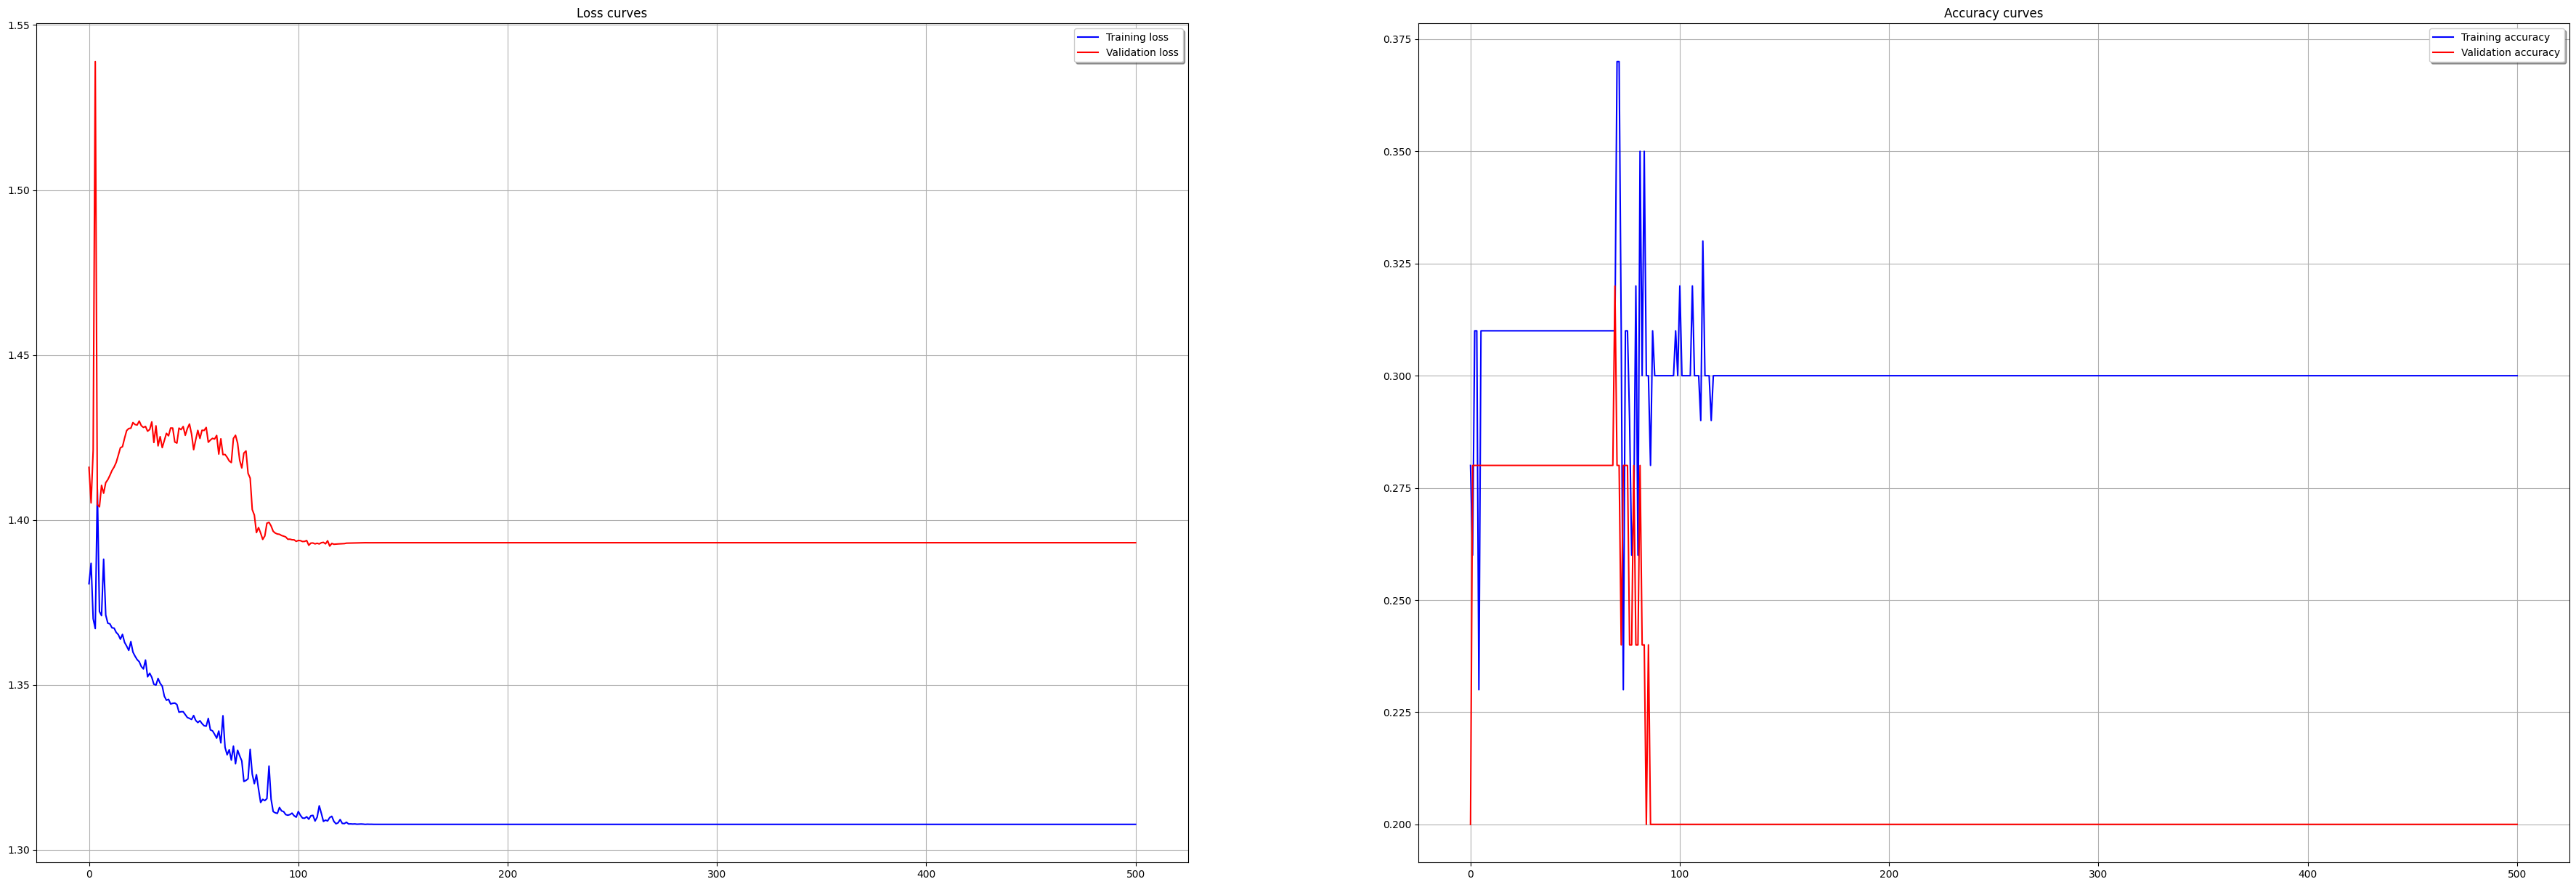

272/272 [==============================] - 9s 31ms/step
0.2845303867403315


In [ ]:
model.save("model_CNN_ggg.keras")

train_loss, train_accuracy = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=64,
                                       verbose=1)

test_loss, test_accuracy = model.evaluate(X_val,
                                                    y_val,
                                                    batch_size=64,
                                                    verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(45,15))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].grid()
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].grid()
axs[1].legend(loc='best', shadow=True)
plt.show()

y_pred = model.predict(X_val)
print(f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='micro'))

In [ ]:
y_test_pred_np = model.predict(X_test_transformed_np)

y_test_pred_class_np = y_test_pred_np.argmax(axis=1)

y_test_pred_class = pd.DataFrame(data={'id': range(y_test_pred_class_np.shape[0]), 'y': y_test_pred_class_np})
y_test_pred_class.to_csv('sol_CNN_ggg.csv', columns=['id', 'y'], index = False)

107/107 [==============================] - 1s 6ms/step


In [ ]:
hhhhhhhh

NameError: name 'hhhhhhhh' is not defined

In [ ]:
learning_rate = 1e-3
num_filter=32
filter_size = 31
num_dense=256
drop_dense=0.7

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=3,
                             verbose=0,
                             factor=0.5,
                             min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0, 
                           patience=25,
                           verbose=1,
                           mode='max',
                           baseline=0.75,
                           start_from_epoch=1,
                           restore_best_weights=True)

In [ ]:
# Model parameters
input_shape = (X_train_partial.shape[1], X_train_partial.shape[2])
num_classes = 4

model = Sequential()

model.add(Conv1D(num_filter, filter_size, padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization(axis=-1))
model.add(Conv1D(num_filter, filter_size, padding='same', activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(2*num_filter, filter_size, padding='same', activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv1D(2*num_filter, filter_size, padding='same', activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling1D(pool_size=2))

#model.add(GlobalAveragePooling1D())
#model.add(Dropout(dropout_rate))
model.add(Flatten())                        

model.add(Dense(num_dense, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

# Model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 300, 32)           10944     
                                                                 
 batch_normalization_25 (Ba  (None, 300, 32)           128       
 tchNormalization)                                               
                                                                 
 conv1d_21 (Conv1D)          (None, 300, 32)           31776     
                                                                 
 batch_normalization_26 (Ba  (None, 300, 32)           128       
 tchNormalization)                                               
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 150, 32)           0         
 ng1D)                                                           
                                                      

In [ ]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=5000,
                    batch_size=64,
                    validation_split=0.0,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    callbacks=[lr_decay, early_stop],
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

Epoch 1/25
296/296 [==============================] - 18s 55ms/step - loss: 1.0063 - accuracy: 0.6372 - val_loss: 0.7959 - val_accuracy: 0.7040 - lr: 0.0010
Epoch 2/25
296/296 [==============================] - 14s 46ms/step - loss: 0.6874 - accuracy: 0.7280 - val_loss: 0.6154 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 3/25
296/296 [==============================] - 14s 46ms/step - loss: 0.6042 - accuracy: 0.7595 - val_loss: 0.5357 - val_accuracy: 0.7872 - lr: 0.0010
Epoch 4/25
296/296 [==============================] - 14s 49ms/step - loss: 0.5235 - accuracy: 0.7890 - val_loss: 0.5536 - val_accuracy: 0.7741 - lr: 0.0010
Epoch 5/25
296/296 [==============================] - 14s 47ms/step - loss: 0.4690 - accuracy: 0.8098 - val_loss: 0.4340 - val_accuracy: 0.8318 - lr: 0.0010
Epoch 6/25
296/296 [==============================] - 13s 45ms/step - loss: 0.4263 - accuracy: 0.8239 - val_loss: 0.4841 - val_accuracy: 0.8143 - lr: 0.0010
Epoch 7/25
296/296 [==============================] - 13s 

16/16 [==============================] - 0s 29ms/step - loss: 0.2758 - accuracy: 0.9060
-----------------------------------------------------------------
train accuracy = 95.9117%
test accuracy = 90.5979%


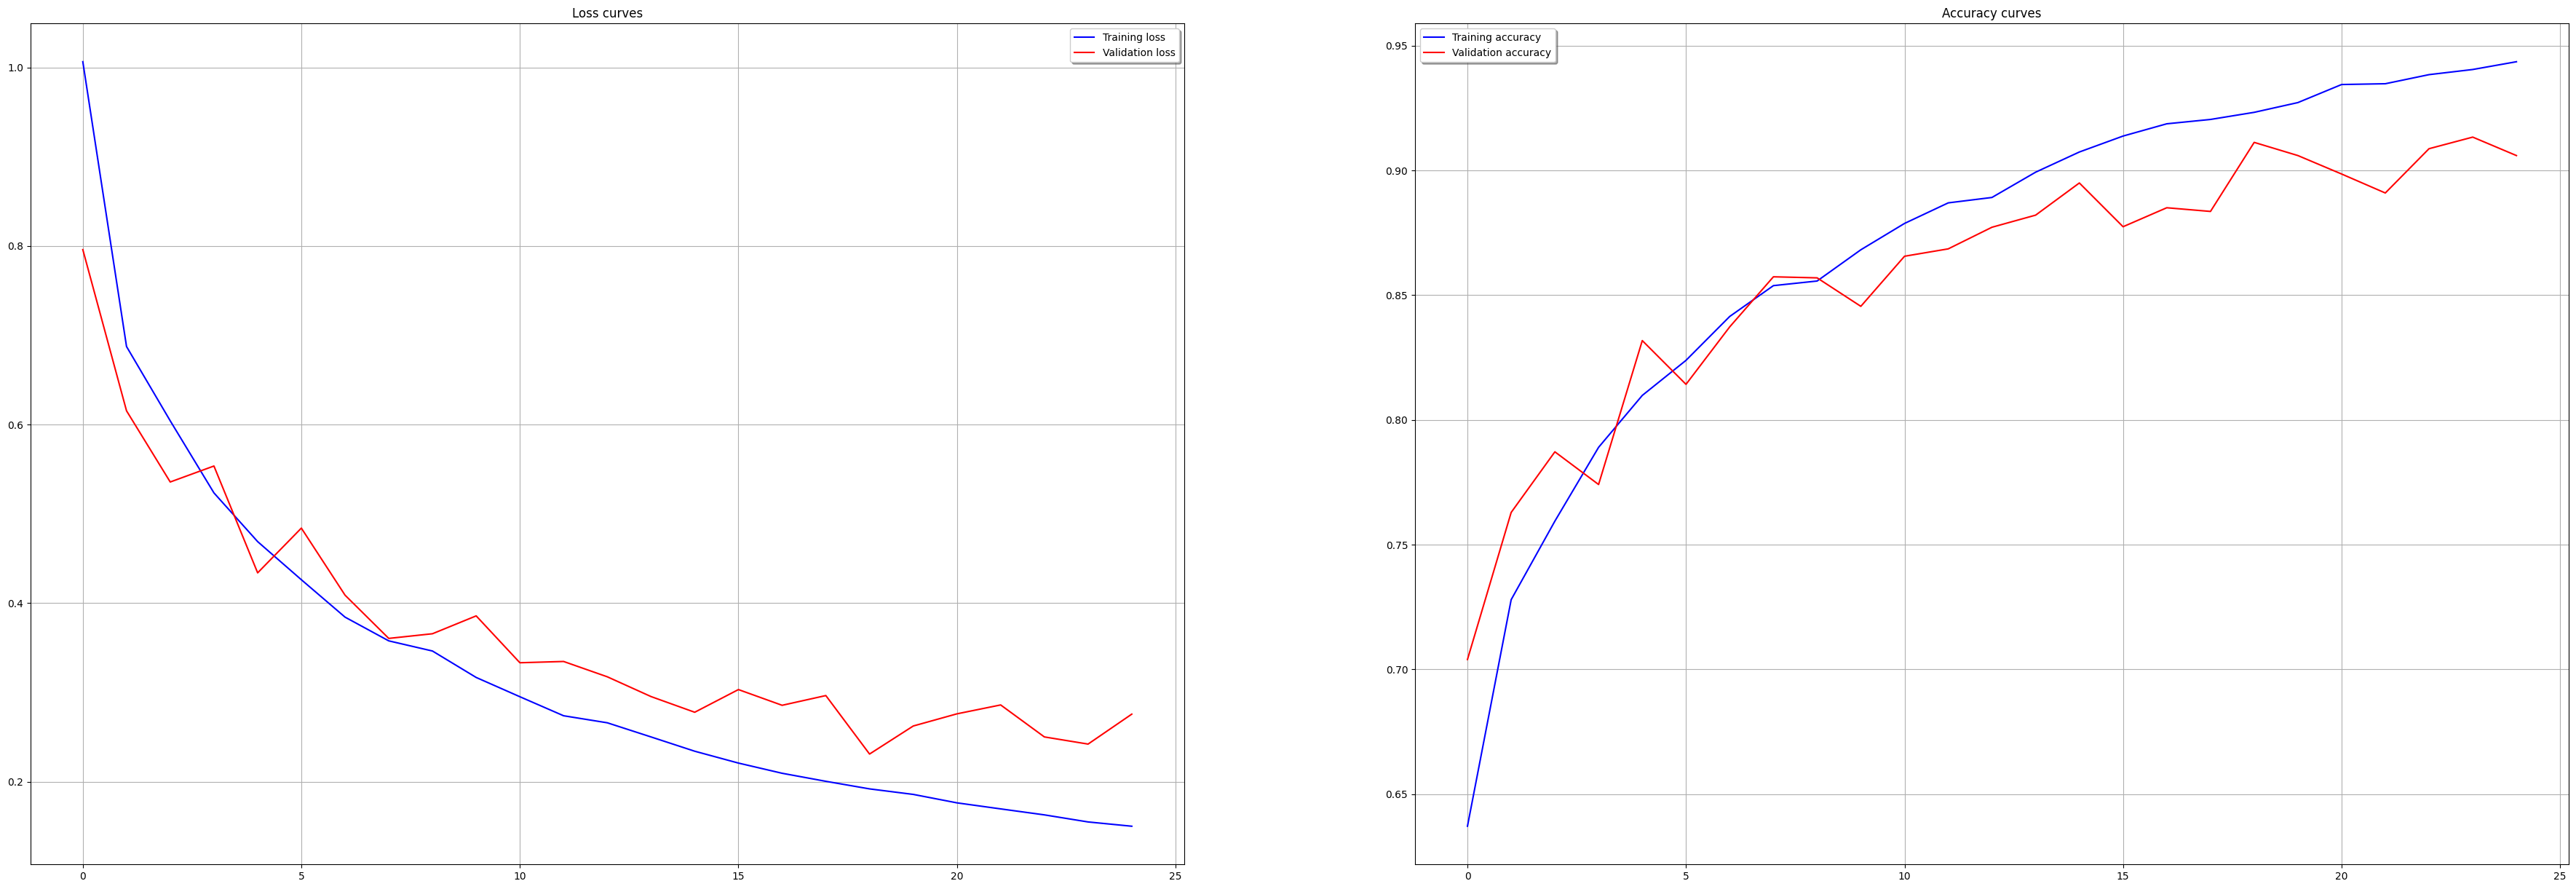

148/148 [==============================] - 2s 9ms/step
0.9059792943165011


In [ ]:
# Evaluate the model:
train_loss, train_accuracy = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=X_train_partial.shape[1],
                                       verbose=1)

test_loss, test_accuracy = model.evaluate(X_val,
                                                    y_val,
                                                    batch_size=X_train_partial.shape[1],
                                                    verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(45,15))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].grid()
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].grid()
axs[1].legend(loc='best', shadow=True)
plt.show()

y_pred = model.predict(X_val)
print(f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='micro'))

In [ ]:
y_test_pred_np = model.predict(X_test_ready_np)

y_test_pred_class_np = y_test_pred_np.argmax(axis=1)

y_test_pred_class = pd.DataFrame(data={'id': range(y_test_pred_class_np.shape[0]), 'y': y_test_pred_class_np})
y_test_pred_class.to_csv('sol_CNN_different2.csv', columns=['id', 'y'], index = False)

107/107 [==============================] - 1s 8ms/step
